<a href="https://colab.research.google.com/github/jefflung/cancer-risk-factors/blob/main/Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
df = pd.read_excel('/content/drive/MyDrive/assignment/cancer-risk-factors (CODECADEMY).xlsx')

In [13]:
print(df.head())
print(df.info())
print(df.columns)

  Patient_ID Cancer_Type  Age  Gender  Smoking  Alcohol_Use  Obesity  \
0     LU0000      Breast   68       0        7            2        8   
1     LU0001    Prostate   74       1        8            9        8   
2     LU0002        Skin   55       1        7           10        7   
3     LU0004        Lung   67       1       10            7        4   
4     LU0005        Lung   77       1       10            8        3   

   Family_History  Diet_Red_Meat  Diet_Salted_Processed  ...  \
0               0              5                      3  ...   
1               0              0                      3  ...   
2               0              3                      3  ...   
3               0              6                      3  ...   
4               0              6                      0  ...   

   Physical_Activity  Air_Pollution  Occupational_Hazards  BRCA_Mutation  \
0                  4              6                     3              1   
1                  1          

In [14]:
# Data Preprocessing

print("\n" + "-" * 50 + "\nData Preprocessing\n" + "-" * 50)

# Create a copy to preserve original data
df_processed = df.copy()

# Encode categorical variables
print("\nEncoding categorical variables...")

# Gender encoding
le_gender = LabelEncoder()
df_processed['Gender'] = le_gender.fit_transform(df_processed['Gender'])
print(f"Gender encoding: {dict(zip(le_gender.classes_, le_gender.transform(le_gender.classes_)))}")

# Smoking encoding
le_smoking = LabelEncoder()
df_processed['Smoking'] = le_smoking.fit_transform(df_processed['Smoking'])
print(f"Smoking encoding: {dict(zip(le_smoking.classes_, le_smoking.transform(le_smoking.classes_)))}")

# Risk Level encoding (target var)
le_risk = LabelEncoder()
df_processed['Risk_Level'] = le_risk.fit_transform(df_processed['Risk_Level'])
print(f"Risk Level encoding: {dict(zip(le_risk.classes_, le_risk.transform(le_risk.classes_)))}")

# Seperate features and target
# Drop non-numeric columns that are not releveant for scaling
x = df_processed.drop(['Risk_Level', 'Patient_ID', 'Cancer_Type','Overall_Risk_Score'], axis=1)
y = df_processed['Risk_Level']

print(f"\nFeatures shape: {x.shape}")
print(f"Target shape: {y.shape}")


--------------------------------------------------
Data Preprocessing
--------------------------------------------------

Encoding categorical variables...
Gender encoding: {np.int64(0): np.int64(0), np.int64(1): np.int64(1)}
Smoking encoding: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(6): np.int64(6), np.int64(7): np.int64(7), np.int64(8): np.int64(8), np.int64(9): np.int64(9), np.int64(10): np.int64(10)}
Risk Level encoding: {'High': np.int64(0), 'Low': np.int64(1), 'Medium': np.int64(2)}

Features shape: (497, 17)
Target shape: (497,)


In [15]:
# Train and Test Split
print("\n" + "-" * 50 + "\nSplitting data for train and test\n" + "-" * 50)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train set size: {x_train.shape[0]}")
print(f"Test set size: {x_test.shape[0]}")

# Scale features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

print("Features scaled successfully!")


--------------------------------------------------
Splitting data for train and test
--------------------------------------------------
Train set size: 397
Test set size: 100
Features scaled successfully!


In [16]:
# Models comparison
print("\n" + "-" * 50 + "\nComparing multiple models\n" + "-" * 50)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='mlogloss'),
    'SVM': SVC(random_state=42, kernel='rbf'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Train the model
    model.fit(x_train_scaled, y_train)

    # Make Prediction
    y_pred = model.predict(x_test_scaled)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Cross validation score
    cv_scores = cross_val_score(model, x_train_scaled, y_train, cv=5, scoring='accuracy')
    cv_scores_mean = cv_scores.mean()

    results[name] = {
        'Accuracy': accuracy,
        'F1 Score': f1,
        'CV Score': cv_scores_mean
    }

    print(f"Test accuracy: {accuracy:.4f}")
    print(f"Test F1 score: {f1:.4f}")
    print(f"Cross-validation score: {cv_scores_mean:.4f}")
    print(f"\nClassification report:")
    print(classification_report(y_test, y_pred, target_names=le_risk.classes_))


--------------------------------------------------
Comparing multiple models
--------------------------------------------------

Training Logistic Regression...
Test accuracy: 0.8700
Test F1 score: 0.8687
Cross-validation score: 0.9066

Classification report:
              precision    recall  f1-score   support

        High       0.82      0.86      0.84        21
         Low       0.91      0.95      0.93        43
      Medium       0.85      0.78      0.81        36

    accuracy                           0.87       100
   macro avg       0.86      0.86      0.86       100
weighted avg       0.87      0.87      0.87       100


Training Random Forest...
Test accuracy: 0.8400
Test F1 score: 0.8362
Cross-validation score: 0.8865

Classification report:
              precision    recall  f1-score   support

        High       0.92      0.57      0.71        21
         Low       0.93      0.93      0.93        43
      Medium       0.73      0.89      0.80        36

    accuracy  


--------------------------------------------------
Visualizing models comparison
--------------------------------------------------

Model comparison:
                     Accuracy  F1 Score  CV Score
Logistic Regression      0.87  0.868670  0.906646
SVM                      0.87  0.868552  0.891646
Random Forest            0.84  0.836235  0.886519
XGBoost                  0.85  0.849538  0.861297
Gradient Boosting        0.82  0.817707  0.851297


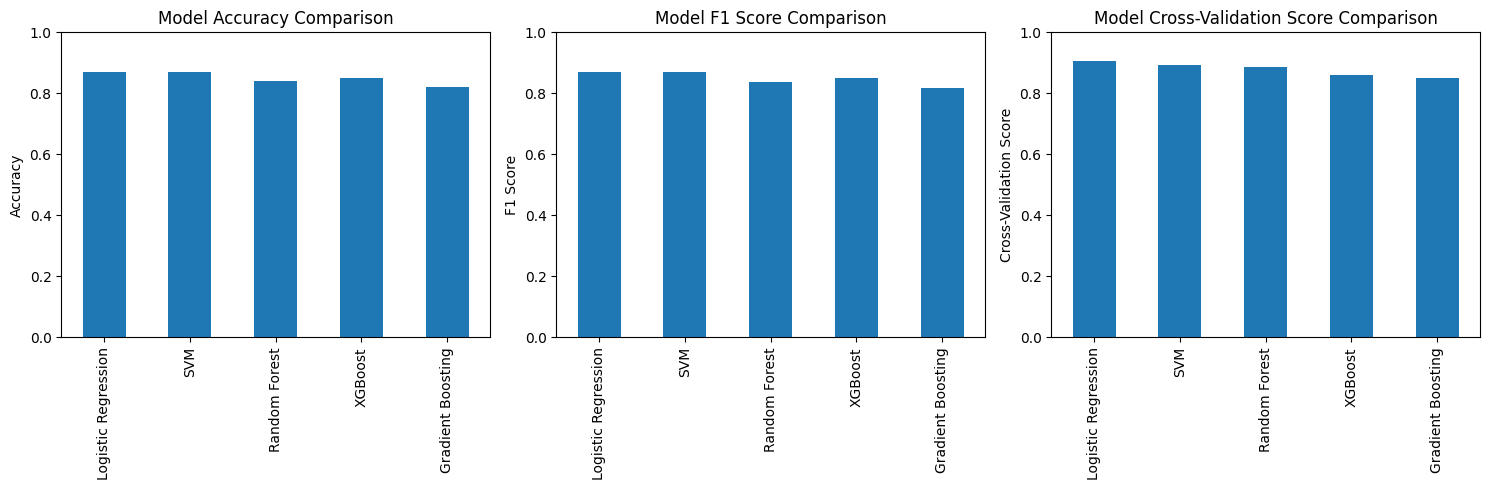


Best model: Logistic Regression
Best model accuracy: 0.8700


In [17]:
# Visualize models comparison
print("\n" + "-" * 50 + "\nVisualizing models comparison\n" + "-" * 50)

# Create comparison dataframe
comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df.sort_values(by='CV Score', ascending=False)

print("\nModel comparison:")
print(comparison_df)

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

comparison_df['Accuracy'].plot(kind='bar', ax=axes[0], title='Accuracy')
axes[0].set_title('Model Accuracy Comparison')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim([0,1])

comparison_df['F1 Score'].plot(kind='bar', ax=axes[1], title='F1 Score')
axes[1].set_title('Model F1 Score Comparison')
axes[1].set_ylabel('F1 Score')
axes[1].set_ylim([0,1])

comparison_df['CV Score'].plot(kind='bar', ax=axes[2], title='Cross-Validation Score')
axes[2].set_title('Model Cross-Validation Score Comparison')
axes[2].set_ylabel('Cross-Validation Score')
axes[2].set_ylim([0,1])

plt.tight_layout()
plt.show()

# Best model
best_model_name = comparison_df['Accuracy'].idxmax()
print(f"\nBest model: {best_model_name}")
print(f"Best model accuracy: {comparison_df.loc[best_model_name, 'Accuracy']:.4f}")


--------------------------------------------------
Hyperparameter tuning for best model
--------------------------------------------------

Tuning Logistic Regression...

Best parameters: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation score: 0.8992

Tuned model accuracy: 0.8600

Tuned model classification report:
              precision    recall  f1-score   support

        High       0.80      0.76      0.78        21
         Low       0.93      0.95      0.94        43
      Medium       0.81      0.81      0.81        36

    accuracy                           0.86       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.86      0.86      0.86       100



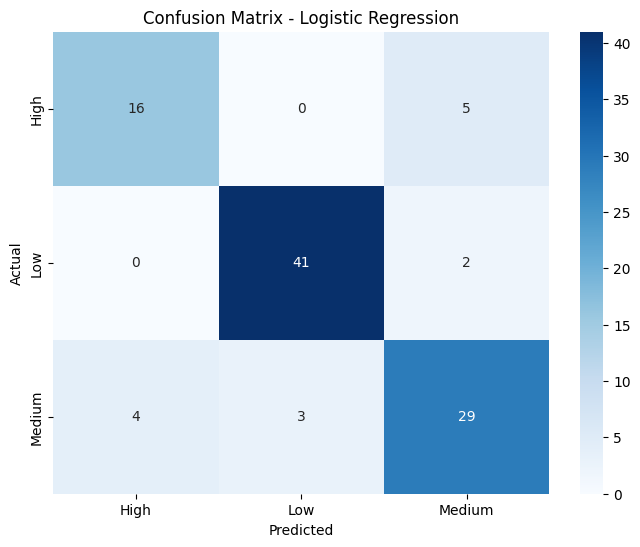

In [19]:
# Hyperparameter tuning for best model
print("\n" + "-" * 50 + "\nHyperparameter tuning for best model\n" + "-" * 50)

# Define parameter grids for to models
param_grid = {
    'Logistic Regression': {
        'C': [0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear'] # 'liblinear' supports both 'l1' and 'l2' penalties
    },
    'Gradient Boosting': {
         'n_estimators': [100,200,300],
         'learning_rate': [0.01, 0.1,0.3],
         'max_depth': [3, 5, 7],
         'subsample': [0.8,0.9,1.0]
     },
     'Random Forest': {
         'n_estimators': [100,200,300],
         'max_depth': [10, 20, None],
         'min_samples_split': [2, 5, 10],
         'min_samples_leaf': [1,2,4]
     },
     'XGBoost': {
         'n_estimators': [100,200,300],
         'learning_rate': [0.01, 0.1, 0.3],
         'max_depth': [3, 5, 7],
         'subsample': [0.8, 0.9, 1.0]
     }
}

# Tune the best model
if best_model_name in param_grid:
  print(f"\nTuning {best_model_name}...")

  best_model = models[best_model_name]
  param_grid_model = param_grid[best_model_name]

  grid_search = GridSearchCV(best_model, param_grid_model, cv=5, scoring='accuracy')

  grid_search.fit(x_train_scaled, y_train)

  print(f"\nBest parameters: {grid_search.best_params_}")
  print(f'Best cross-validation score: {grid_search.best_score_:.4f}')

# Evaluate tuned model
# This block will now execute because grid_search will be defined
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(x_test_scaled)
tuned_accuracy = accuracy_score(y_test, y_pred_tuned)

print(f"\nTuned model accuracy: {tuned_accuracy:.4f}")
print("\nTuned model classification report:")
print(classification_report(y_test, y_pred_tuned, target_names=le_risk.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_risk.classes_, yticklabels=le_risk.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.show()

In [20]:
# Feature Importance

if best_model_name in ['Gradient Boosting', 'Random Forest', 'XGBoost']:
  print("\n" + "-" * 50 + "\nFeature importance\n" + "-" * 50)

  feature_importance = pd.DataFrame({
      'Feature': x.columns,
      'Importance': best_model.feature_importances_
  }).sort_values(by='Importance', ascending=False)

  print("\n", feature_importance)

  plt.figure(figsize=(10, 6))
  plt.barh(feature_importance['Feature'], feature_importance['Importance'])
  plt.xlabel('Importance')
  plt.title(f'Feature Importance - {best_model_name}')
  plt.gca().invert_yaxis()
  plt.tight_layout()
  plt.show()

In [21]:
# Summary
print("\n" + "-" * 50 + "\nSummary\n" + "-" * 50)
print(f"Best model: {best_model_name}")
print(f"Best model accuracy: {tuned_accuracy:.4f}")


--------------------------------------------------
Summary
--------------------------------------------------
Best model: Logistic Regression
Best model accuracy: 0.8600
